# Unsupervised Learning

General idea: give an ML model a bunch of images of working and defective products, but don't give it the working/not working labels.

Unsupervised tasks:
- Dimensionality Reduction (ch7)
- Clustering - recommendations, search engines, dimensionality reduction. 
- Anomaly Detection - learn what "normal" is, then use that to find not normal. Good for fraud/defective detection, time series trends, removing outliers (GREAT for data cleaning)
- Density Estimation - estimating pdf of random process that made the dataset


## Clustering: k means and DBSCAN

useful clustering applications: customer segmentation, data analysis, dimensionality reduction, feature engineering, anomaly detection, semi-supervised learning, search engines, image segmentation

### k means clustering

In [2]:
# boilerplate
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

X, y, cens= make_blobs(500, centers = 5, return_centers=True)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
yPred = kmeans.fit_predict(X)
yPred is kmeans.labels_

c:\Users\willh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


True

In [3]:
kmeans.cluster_centers_

array([[ 6.78695281,  3.55212821],
       [-2.66153816, -6.86437925],
       [-6.82526325,  6.10945405],
       [ 2.62573283,  2.48443396],
       [ 0.67320819, -9.94469543]])

Hard clustering: assign each new instance to a cluster

Soft clustering: give %s that an instance is in each cluster

#### k means algorithm

1) randomly guess n centroids
2) label every instance with the centroid
3) update centroids to their instances means
4) repeat 2-3-4

This converges, but might not be right. Might end up with 2 centroids fitting 1 blob and 1 centroid fitting 2 blobs.

##### Centroid initialization methods

If you have an idea with the centroids should be:

In [4]:
import numpy as np
goodInit = np.array([[3,3], [-1,5], [6,7], [9,-4], [1,1]])
# my init is random and probably actually bad
kmeans = KMeans(n_clusters=5, init=goodInit)
kmeans.fit(X)

# kmeans.inertia_

c:\Users\willh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(init=array([[ 3,  3],
       [-1,  5],
       [ 6,  7],
       [ 9, -4],
       [ 1,  1]]),
       n_clusters=5)

You could also just run the algo multiple times and keep the best solution. Number of random initializations is controlled by `n_init`. Scikitlearn does 10, and keeps the best with a models *inertia*

$\text{inertia} = \sum_{i=1}^{m} \left\| \mathbf{x}^{(i)} - {c^{(i)}} \right\|^2$

Inertia is the sum of all distances between x^i and the closest centroid c^i

Sklearn uses a k-means++ algorithm that tends to choose random centroids that are further away from each other, which is proven to converge more quickly/reliably. 

### Accelerated k-means and mini batch k-means

For big datasets with lots of clusters, you can accelerate kmeans by keeping track of lower/upper bounds for distances btwn centroids and instances. This doesnt always help, might even hurt. but you can set `algorithm="elkan"`

Mini batch: Instead of using every data point at each iteration, just use small batches of data and move centroids a little bit.

In [5]:
from sklearn.cluster import MiniBatchKMeans
mini = MiniBatchKMeans(n_clusters=5)
mini.fit(X)

c:\Users\willh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


MiniBatchKMeans(n_clusters=5)

#### Finding optimal n clusters

You cant just optimize for inertia because more centroids = lower inertia.

Silhouette score: mean silhouette coefficient over all instaces. Coefficient for each instance = (b-a) / max(a,b) where a is mean distance to all instances in same cluster, and b is the mean nearest cluster distance (avg distance to instances in next closest cluster)

Coefficient of 1 means an instance is firmly inside its own cluster and far from other cluster. -1 means the instance is probably not in the right cluster.

In [6]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.6430434569369896

If you plot every instances silhoutte coefficient, sorted by clusters and value of coefficient, you get a silhouette diagram. Looks like a knife plot. If you plot the average silhoutte score across all instances as a vertical line, the very best n clusters will tend to be very uniform and all poking past the mean.

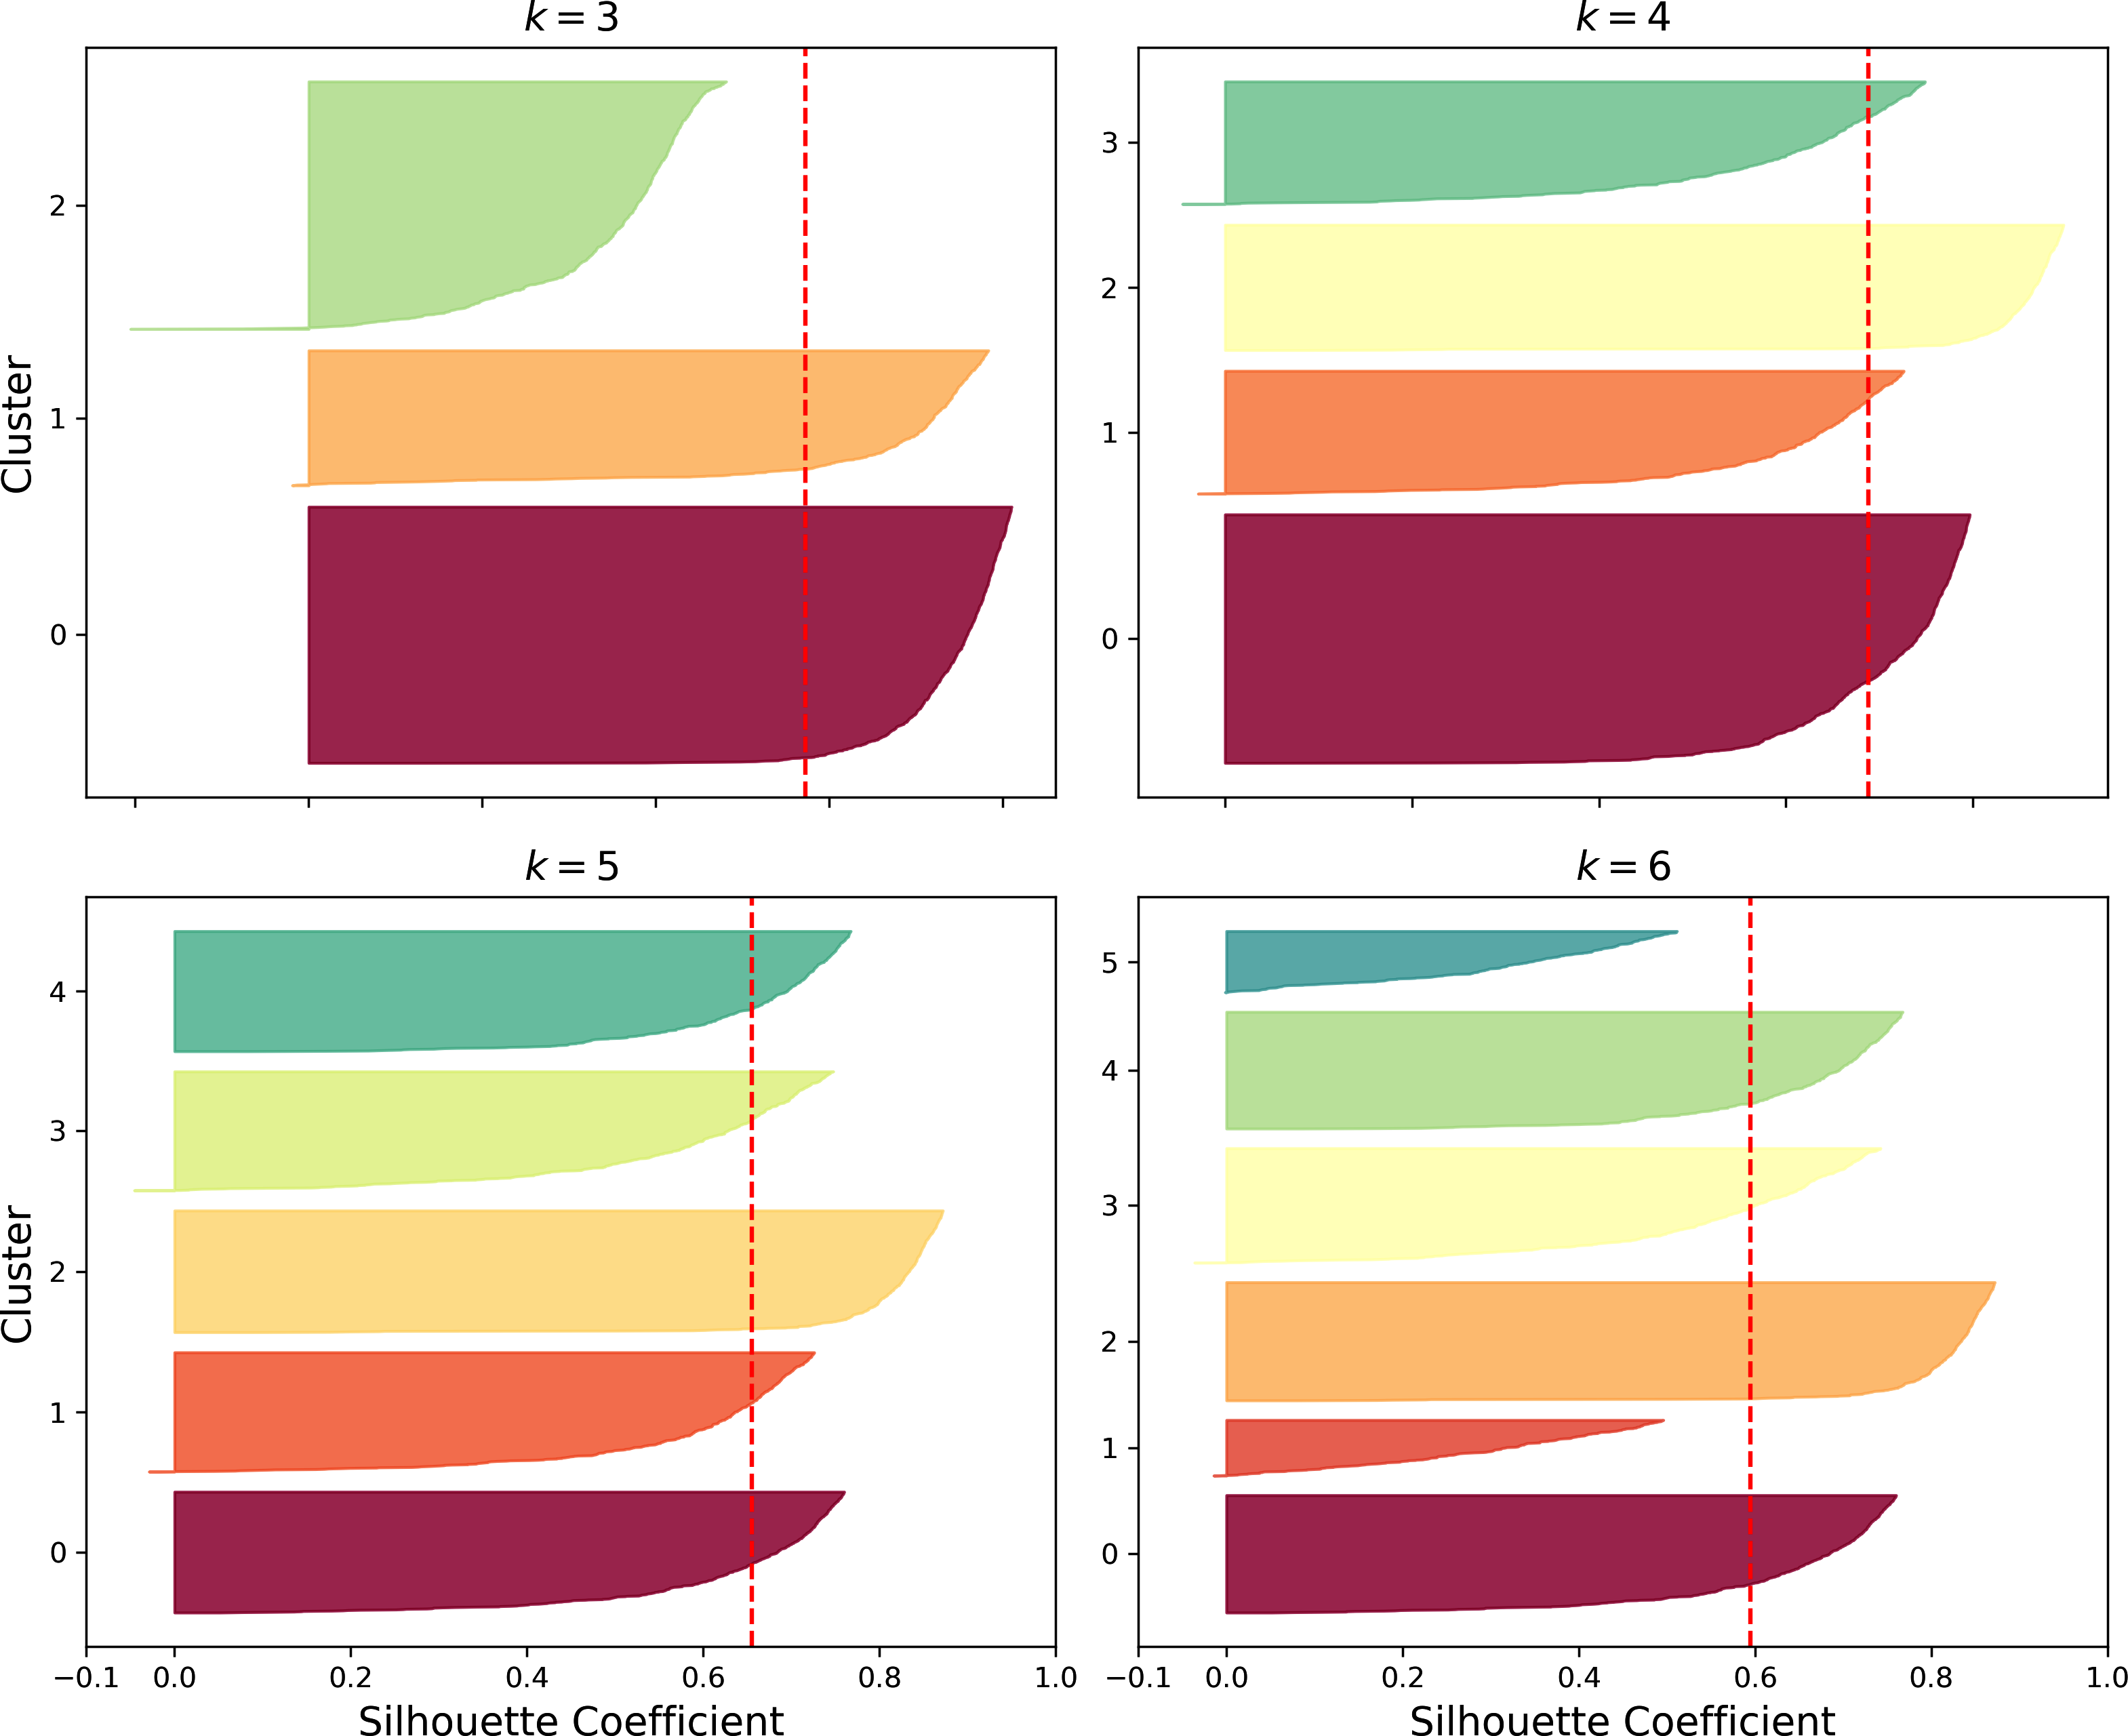

### Limits of k-means

Its fast, but you need to run it multiple times, and specify the number of clusters. It also doesnt do very well on noncircular clusters

Scaling features can help k-means a lot, so make sure you do that if you want kmeans to work well.

## Clustering for Image Segmentation

Image segmentation: break image into multiple parts

- color segmentation: group pixels by color. good for satellite data
- semantic segmentation: all pixels apart of the same object type get grouped (ie a self driving car makes one pedestrian blob)
- instance segmentation: all pixels apart of one object get grouped (one segment per pedestrian)

In [7]:
from PIL import Image
img = Image.open("datasets/ladybug.jpg")
image = np.asarray(img.resize((img.width // 8, img.height // 8)))
image.shape
# 3 is the rgb colors

(456, 684, 3)

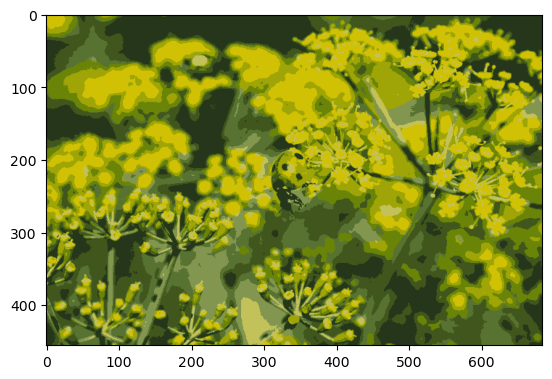

In [8]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8).fit(X)
segmented = kmeans.cluster_centers_[kmeans.labels_]
segmented = segmented.reshape(image.shape)

import matplotlib.pyplot as plt
plt.imshow(segmented.astype(np.uint8))
plt.show()

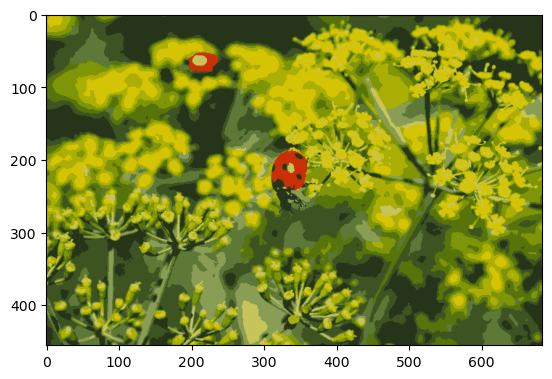

In [9]:
kmeans = KMeans(n_clusters=10).fit(X)
segmented = kmeans.cluster_centers_[kmeans.labels_]
segmented = segmented.reshape(image.shape)

import matplotlib.pyplot as plt
plt.imshow(segmented.astype(np.uint8))
plt.show()

## Clustering and Semi-Supervised Learning

Semi supervised: lots of data, few labels

In [10]:
from sklearn.datasets import load_digits

Xdigits, ydigits = load_digits(return_X_y=True)
Xtrain, ytrain = Xdigits[:1400], ydigits[:1400]
Xtest, ytest = Xdigits[1400:], ydigits[1400:]

In [11]:
# Pretend you only have 50 labels
from sklearn.linear_model import LogisticRegression
nLabels = 50
logReg = LogisticRegression(max_iter=10000)
logReg.fit(Xtrain[:nLabels], ytrain[:nLabels])
logReg.score(Xtest,ytest)
# 50 instances simply isnt enough to train on

0.7581863979848866

Do better by clustering, then find image closest to each centroid

In [21]:
k=50
kmeans = KMeans(n_clusters=k, random_state=42)
XdigitsDist = kmeans.fit_transform(Xtrain)
repDigitsIdxs = XdigitsDist.argmin(axis=0) # this gets the instances closest to centroid for labeling
XrepDigits = Xtrain[repDigitsIdxs]
yrepDigits = ytrain[repDigitsIdxs] # usually you would have to manually label but we have real labels

c:\Users\willh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [22]:
logReg = LogisticRegression(max_iter=10000)
logReg.fit(XrepDigits, yrepDigits)
logReg.score(Xtest, ytest)

0.8312342569269522

We get ~8% better accuracy by having representative labels rather than randomly labeling some data.

Other method: label propagation. Use representative labels to label all instances in cluster.

In [24]:
yTrainProp = np.empty(len(Xtrain), dtype=np.int64)
for i in range(k):
    yTrainProp[kmeans.labels_==i] = yrepDigits[i]

logReg = LogisticRegression(max_iter=10000)
logReg.fit(Xtrain, yTrainProp)
logReg.score(Xtest, ytest)

0.871536523929471

Another big accuracy jump. Having more data (even machine labeled) helps a lot.

We can do the same thing but only keep the 50% of instances closest to a cluster (the "clearest" digits)

In [25]:
percClosest = 50
XClusterDist = XdigitsDist[np.arange(len(Xtrain)), kmeans.labels_]
for i in range(k):
    inCluster = (kmeans.labels_ == i)
    clusterDist = XClusterDist[inCluster]
    cutoffDist = np.percentile(clusterDist, percClosest)
    aboveCutoff = (XClusterDist > cutoffDist)
    XClusterDist[inCluster & aboveCutoff] = -1

partiallyProp = (XClusterDist != -1)
XtrainPartialProp = Xtrain[partiallyProp]
ytrainPartialProp = ytrain[partiallyProp]

logReg = LogisticRegression(max_iter=10000)
logReg.fit(XtrainPartialProp, ytrainPartialProp)
logReg.score(Xtest, ytest)

0.8765743073047859

Small accuracy jump this time. This works well because our propagated labels line up with real labels very well:

In [35]:
(ytrainPartialProp == ytrain[partiallyProp]).mean()

1.0

Sklearn has some classes that can do automatic label prop: `LabelSpreading`, `LabelPropagation` in `sklearn.semi_supervised`

**Active Learning**: A human identifies the instances the model is least sure about. You can repeat this until the models improvement stops.

## DBScan

Density based spatial clustering of applications with noise.

Steps:
1) For each instance, count how many other instances are within small distance $\epsilon$
2) If an instance has `min_samples` neighbors, it is a "core instance" within a dense region
3) All instances in the neighborhood of a core instance are in the the same overall cluster. One cluster can have >1 core instance.
4) Any instance not a core and not in a core neighborhood is an anomaly.

In [55]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=1000, noise=.05)
dbscan = DBSCAN(eps=.05, min_samples=5)
dbscan.fit(X)
dbscan.labels_[:10] # -1 = anomaly

# dbscan.core_sample_indices_
# dbscan.components_ # core values

array([-1,  2,  1,  0,  1,  0,  2,  3,  2,  0], dtype=int64)

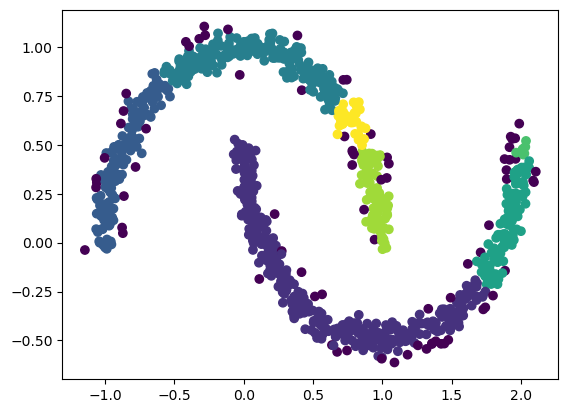

In [61]:
plt.scatter(X[:,0],X[:,1], c=dbscan.labels_)
# Obviously there should be 2 clusters, but dbscan finds 7
# solution: increase eps

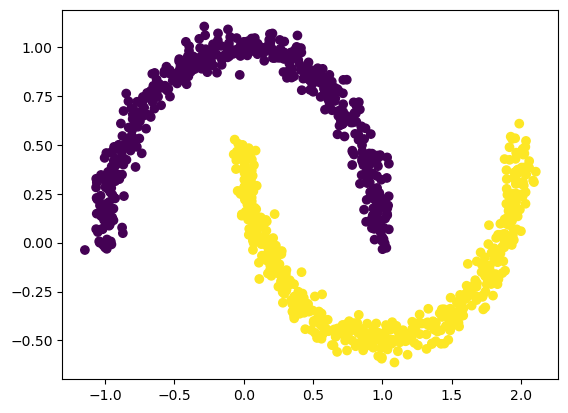

In [65]:
dbscan = DBSCAN(eps=.2, min_samples=5)
dbscan.fit(X)
plt.scatter(X[:,0],X[:,1], c=dbscan.labels_)

DBSCAN doesnt have a predict method, so you have to make your own:

In [68]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])
Xnew = np.array([[0,1], [-.5,1], [1,-.25]])
display(knn.predict(Xnew))
knn.predict_proba(Xnew)

# Only trained on core instances, but you can pick which data to train on

array([0, 0, 1], dtype=int64)

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [0.14, 0.86]])

KNN will always choose a cluster even if you enter like 5000,5000. To add anomaly classification:

In [72]:
yDist, yPredIdx = knn.kneighbors(Xnew, n_neighbors=1)
yPred = dbscan.labels_[dbscan.core_sample_indices_][yPredIdx]
yPred[yDist>.2] = -1
# .2 can be fine tuned

DBSCAN is robust to outliers, but if density varies across clusters or clusters overlap/are packed together, DBSCAN struggles. Also its $O(m^2n)$

Can also test `sklearn.cluster.HDBSCAN`, better with variable density clusters

## Other Clustering Algorithms

- Agglomerative Clustering: Builds a hierarchy of clusters. Each step connects nearest clusters, building a binary cluster tree. Can scale well to large datasets with a connectivity matrix.
- BIRCH: Balanced Iterative Reducing and Clustering using Hierarchies. With low n features, does as well as k-means and is fast, so good for big data. Builds trees with the minimum info needed to assign instances to clusters.
- Mean-shift: For each instance, make a circle around it, and calculate the mean params for each instance in the circle. Shift the circle to the means location, and redo. Once all circles have stopped moving, algo stops, finding the local density max's. All instances who's circles are close enough are in the same cluster. Bad complexity, so doesn't work for large data.
- Affinity Propagation: instances "message" each other until every instance picks an exemplar to represent it. Each exemplar and its voters are a cluster. Works well, tends to pick exemplars need center of clusters and doesn't need you to specify n_clusters beforehand, but bad for large data.
- Spectral Clustering: take a similarity matrix between instances, reduces its dimensionality, then uses another clustering algo in this low-dimension space. Can find odd clusters, but doesnt scale or do well when clusters are very different sizes.

## Gaussian Mixtures

GMMs (gaussian mixture models) assume every instance generated from various unknown normal distributions.

Several GMM variants. Simplest one: you know the number of gaussian distributions in advance. The dataset was generated through this process (assumed): For each instance, a random cluster (from k clusters) was picked. The probability of picking this cluster j is the cluster weight $\phi^j$. If instance i was assigned to cluster j, the location $x^i$ of this instance is randomly sampled from gaussian distribution with mean %\mu^j$ and covariance matrix $\Sigma^j$.This is written as $x^i \sim N(\mu^j, \Sigma^j)$

In [79]:
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore") #kmeans has a windows memory leak

gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [80]:
gm.weights_
# gm.means_
# gm.covariances_

# weights are the prob of assigning some instance to that cluster

array([0.20216552, 0.19187005, 0.60596443])

Gaussian mixture tends to find the correct weights, means, and covariances thru the Expectation-Maximization (EM) algorithm. Very similar to kmeans, that doesnt only find centers but also size, shape, etc by finding covariances too, and weights.

EM uses soft clustering vs kmeans hard clustering. However, like kmeans, EM should be run multiple times (`n_init`) to avoid finding a bad solution.

In [84]:
gm.converged_
gm.n_iter_
# These will tell you whether gm converged and how many iterations it took

19

In [85]:
# You can predict clusters or cluster probabilites now
gm.predict(X)
gm.predict_proba(X)

array([[5.31156574e-038, 1.20287903e-068, 1.00000000e+000],
       [1.67752247e-002, 7.58826168e-176, 9.83224775e-001],
       [9.98976435e-001, 2.26119834e-231, 1.02356486e-003],
       ...,
       [1.84229066e-083, 3.63556106e-032, 1.00000000e+000],
       [6.46891672e-001, 1.49177629e-198, 3.53108328e-001],
       [9.99784182e-001, 3.71157692e-241, 2.15818479e-004]])

In [88]:
# GMM is a generative model, so you can sample new instances
# Note new samples are ordered by cluster index

Xnew, ynew, = gm.sample(3)
Xnew, ynew

(array([[-0.81746563,  0.37135466],
        [ 0.67239261,  0.24633534],
        [ 0.81889929, -0.29925372]]),
 array([0, 2, 2]))

In [92]:
# You can also do density estimates at any given x
gm.score_samples(X).round(2)[:5] # higher score = higher density
np.exp(gm.score_samples(X).round(2)[:5]) # these are densities, so can be any positive number

array([0.11883729, 0.11417762, 1.        , 0.18268352, 0.52204578])

EM can struggle with high dimension / many cluster / low instance data. You can help it by setting constraints on `covariance_type` hyperparam. Spherical constraint forces spherical clusters, diag forces clusters to have axes parallel to the coordinate axes (diagonal covariance matrix), tied forces identical clusters.

Tied and full (default) are slowest, spherical and diag run faster.

### Gaussian Mixtures for Anomaly Detection